In [1]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pickle
from collections import defaultdict
from tqdm import tqdm
import torch
import clip
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, RepeatVector, Dot, Activation, Lambda, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from PIL import Image

In [3]:
# Get the data
INPUT_DIR = r'C:\Users\gauta\OneDrive\Desktop\Image-Captioner\Image-captioning\Data'
OUTPUT_DIR = r'C:\Users\gauta\OneDrive\Desktop\Image-Captioner\Image-captioning\Results'

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [4]:
# load clip model and preprocessing pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device) # load the clip model

clip_preprocess = Compose([
    Resize((224, 224)),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

In [5]:
# Extract clip features
def extract_clip_features(img_dir):
    valid_extensions = {".jpg", ".png", "jpeg"}
    clip_features = {}
    for img_name in tqdm(os.listdir(img_dir), desc="Processing Images"):
        img_path = os.path.join(img_dir, img_name)
        # check whether the input is valid image
        if not os.path.splitext(img_name)[1].lower() in valid_extensions:
            continue # if the obtained input is not an image
        try:
            img = Image.open(img_path).convert("RGB")
            img_tensor = preprocess(img).unsqueeze(0).to(device)
            with torch.no_grad():
                img_feature = clip_model.encode_image(img_tensor).cpu().numpy()
            img_id = os.path.splitext(img_name)[0]
            clip_features[img_id] = img_feature
        except Exception as e:
            print(f"Error Processing {img_name}: {e}")
            continue
    return clip_features

In [6]:
# preprocess caption as sequences
def preprocess_captions(captions_file):
    image_to_caption_mapping = defaultdict(list)
    with open(captions_file, 'r', encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(',', 1)
            if len(parts) < 2:
                continue # should contain img, captions pairs
            image_id = parts[0].split('.')[0]
            caption = parts[1].lower()
            caption = ''.join(char for char in caption if char.isalnum() or char.isspace())
            caption = 'startseq ' + caption + ' endseq'
            image_to_caption_mapping[image_id].append(caption)
    return image_to_caption_mapping

In [7]:
# Prepare data for training
def prepare_data(image_id, image_to_caption_mapping, features, tokenizer, max_caption_length, vocab_size):
    X1, X2, y = [], [], [] # X1 is image features, X2 is caption sequences and y is next sequence
    captions = image_to_caption_mapping[image_id]
    for caption in captions:
        caption_seq = tokenizer.texts_to_sequences([caption])[0] # convert captions to sequences
        for i in range(1, len(caption_seq)):
            in_seq = pad_sequences([caption_seq[:i]], maxlen=max_caption_length, padding='pre')[0] # input sequence
            out_seq = caption_seq[i]
            X1.append(features[image_id].flatten())
            X2.append(in_seq)
            y.append(out_seq)
    return X1, X2, y

In [8]:
# data generator function
def data_generator(image_ids, image_to_caption_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []
        for image_id in image_ids:
            X1_temp, X2_temp, y_temp = prepare_data(image_id, image_to_caption_mapping, features, tokenizer, max_caption_length, vocab_size)
            X1.extend(X1_temp)
            X2.extend(X2_temp)
            y.extend(y_temp)
            while len(X1) >= batch_size:
                yield (np.array(X1[:batch_size]), np.array(X2[:batch_size])), np.array(y[:batch_size])
                X1, X2, y = X1[batch_size:], X2[batch_size:], y[batch_size:]
                
        

In [9]:
# define CNN + LSTM model
def model(vocab_size, max_caption_length):
    inputs1 = Input(shape=(512,), name="image_features")
    fe1 = Dense(256, activation='relu', name="feature_dense")(inputs1)
    fe2 = RepeatVector(max_caption_length, name="feature_repeat")(fe1)
    
    inputs2 = Input(shape=(max_caption_length,), name="caption_input")
    se1 = Embedding(vocab_size, 256, mask_zero=True, name="Embedding_layer")(inputs2)
    se2 = LSTM(256, return_sequences=True, name="sequence_lstm")(se1)
    
    attention = Dot(axes=[2, 2], name="attention_dot")([fe2, se2])
    attention_scores = Activation('softmax', name="attention_scores")(attention)
    context_vector = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se2])
    context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(context_vector)

    decoder_input = concatenate([context_vector, fe1], name="decoder_input")
    decoder1 = Dense(256, activation='relu', name="decoder_dense")(decoder_input)
    outputs = Dense(vocab_size, activation='softmax', name="output_layer")(decoder1)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())
    return model

In [10]:
# train the model
from sklearn.model_selection import train_test_split

In [11]:
# load features and captions
img_dir = os.path.join(INPUT_DIR, 'Images')
captions_file = os.path.join(INPUT_DIR, 'captions.txt')
loaded_features = extract_clip_features(img_dir)
image_to_caption_mapping = preprocess_captions(captions_file)

Processing Images: 100%|██████████| 31783/31783 [2:31:58<00:00,  3.49it/s]  


In [12]:
for image_id, captions in list(image_to_caption_mapping.items())[:5]:
    print(f"Image ID: {image_id}")
    for caption in captions:
        print(f"Caption: {caption}")

Image ID: image
Caption: startseq caption endseq
Image ID: 1000092795
Caption: startseq  two young guys with shaggy hair look at their hands while hanging out in the yard  endseq
Caption: startseq  two young  white males are outside near many bushes  endseq
Caption: startseq  two men in green shirts are standing in a yard  endseq
Caption: startseq  a man in a blue shirt standing in a garden  endseq
Caption: startseq  two friends enjoy time spent together  endseq
Image ID: 10002456
Caption: startseq  several men in hard hats are operating a giant pulley system  endseq
Caption: startseq  workers look down from up above on a piece of equipment  endseq
Caption: startseq  two men working on a machine wearing hard hats  endseq
Caption: startseq  four men on top of a tall structure  endseq
Caption: startseq  three men on a large rig  endseq
Image ID: 1000268201
Caption: startseq  a child in a pink dress is climbing up a set of stairs in an entry way  endseq
Caption: startseq  a little girl in

In [13]:
# Tokenizer
all_captions = [caption for captions in image_to_caption_mapping.values() for caption in captions]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

print(f"Captions: {len(all_captions)}")

# max caption length
max_caption_length = max(len(caption.split()) for caption in all_captions)

print(f"Vocab size: {vocab_size}")
print(f"Max Caption Length: {max_caption_length}")

Captions: 158916
Vocab size: 20011
Max Caption Length: 80


In [14]:
# split the data
image_ids = [image_id for image_id in image_to_caption_mapping.keys() if image_id in loaded_features] # get valid image ids
train, test = train_test_split(image_ids, test_size=0.1, random_state=42)

In [15]:
print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

Train size: 28604
Test size: 3179


In [16]:
# build model
model = model(vocab_size, max_caption_length)
model.summary()

c:\Users\gauta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'lambda' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_features      │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_dense       │ (None, 256)       │    131,328 │ image_features[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding_layer     │ (None, 80, 256)   │  5,122,816 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 80)        │          0 │ caption_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_repeat      │ (None, 80, 256)   │          0 │ feature_dense[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_lstm       │ (None, 80, 256)   │    525,312 │ Embedding_layer[… │
│ (LSTM)              │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dot (Dot) │ (None, 80, 80)    │          0 │ feature_repeat[0… │
│                     │                   │            │ sequence_lstm[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_scores    │ (None, 80, 80)    │          0 │ attention_dot[0]… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 80, 256)   │          0 │ attention_scores… │
│                     │                   │            │ sequence_lstm[0]… │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256)       │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 512)       │          0 │ lambda_1[0][0],   │
│ (Concatenate)       │                   │            │ feature_dense[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 256)       │    131,328 │ decoder_input[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 20011)     │  5,142,827 │ decoder_dense[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,053,611 (42.17 MB)

 Trainable params: 11,053,611 (42.17 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# call backs
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=os.path.join(OUTPUT_DIR, 'best_model.keras'), save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [18]:
# data generators
batch_size = 32
train_generator = data_generator(train, image_to_caption_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
test_generator = data_generator(test, image_to_caption_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)

In [19]:
for X_batch, y_batch in train_generator:
    print(f"X1 shape: {X_batch[0].shape}, X2 shape: {X_batch[1].shape}, y shape: {y_batch.shape}")
    break

X1 shape: (32, 512), X2 shape: (32, 80), y shape: (32,)


In [20]:
# train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train)//batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=len(test)//batch_size,
    callbacks=callbacks
)

Epoch 1/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 318s 347ms/step - loss: 6.7904 - val_loss: 5.6017 - learning_rate: 0.0010
Epoch 2/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 288s 323ms/step - loss: 5.6218 - val_loss: 5.3906 - learning_rate: 0.0010
Epoch 3/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 310s 347ms/step - loss: 5.3014 - val_loss: 5.0157 - learning_rate: 0.0010
Epoch 4/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 320s 358ms/step - loss: 5.0747 - val_loss: 4.7987 - learning_rate: 0.0010
Epoch 5/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 407s 455ms/step - loss: 4.9591 - val_loss: 4.9878 - learning_rate: 0.0010
Epoch 6/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 360s 403ms/step - loss: 4.8724 - val_loss: 4.6565 - learning_rate: 0.0010
Epoch 7/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 336s 376ms/step - loss: 4.6503 - val_loss: 4.6943 - learning_rate: 0.0010
Epoch 8/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 299s 335ms/step - loss: 4.5230 - val_loss: 4.6614 - learning_rate: 0.0010
Epoch 9/50
893/893 ━━━━━━━━━━━━━━━━━━━━ 291s 326ms/step - loss: 4.4963 - val_loss: 4.544

In [21]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    caption = ['startseq']
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='pre')
        yhat = model.predict([image_features, sequence], verbose=0)
        predicted_index = np.argmax(yhat)
        predicted_word = tokenizer.index_word.get(predicted_index)
        if predicted_word == 'endseq':
            break
        caption.append(predicted_word)
    return ' '.join(caption[1:])

In [22]:
# Evaluate BLEU Scores
def evaluate_model(model, tokenizer, image_to_caption_mapping, test, max_caption_length):
    actual_captions_list, predicted_captions_list = [], []
    smoother = SmoothingFunction()
    for image_id in tqdm(test):
        actual_captions = image_to_caption_mapping[image_id]
        predicted_caption = predict_caption(model, loaded_features[image_id].reshape(1, -1), tokenizer, max_caption_length)
        actual_captions_list.append([caption.split() for caption in actual_captions])
        predicted_captions_list.append(predicted_caption.split())
    print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0), smoothing_function=smoother.method1))
    print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0), smoothing_function=smoother.method1))
    print("BLEU-3: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoother.method1))
    print("BLEU-4: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoother.method1))

In [23]:
# Evaluate
evaluate_model(model, tokenizer, image_to_caption_mapping, test, max_caption_length)

  0%|          | 0/3179 [00:00<?, ?it/s]c:\Users\gauta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'lambda' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
100%|██████████| 3179/3179 [1:41:01<00:00,  1.91s/it]  


BLEU-1: 0.488577
BLEU-2: 0.325069
BLEU-3: 0.210058
BLEU-4: 0.132027


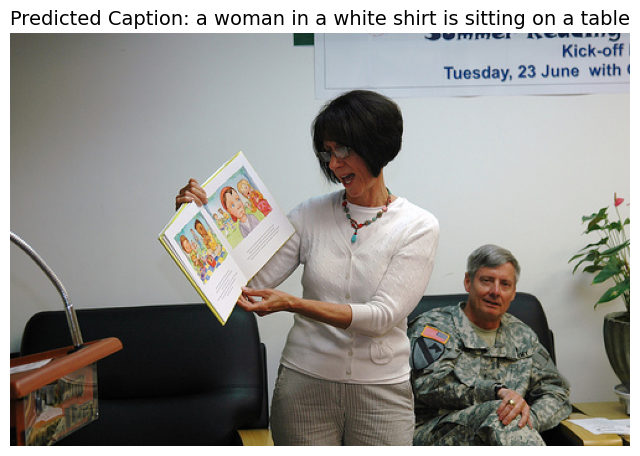

Image ID: 3655176735
Actual Captions:
- startseq  an older woman appears to read from a children s book in an indoor setting  while a seated gentleman in a service uniform looks on  endseq
- startseq  a woman with short black hair and a colorful necklace reads a children s illustration book  endseq
- startseq  a woman with a white shirt holding a children book  endseq
- startseq  a woman reading a children s book  endseq
- startseq  a lady reading a story book  endseq
Predicted Caption: a woman in a white shirt is sitting on a table
--------------------------------------------------


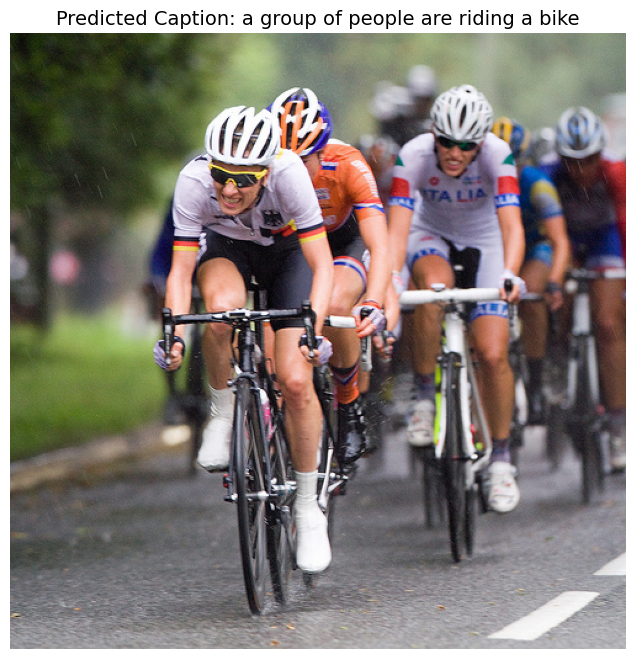

Image ID: 7669392800
Actual Captions:
- startseq  numerous bicyclists wearing bicyclist apparel  helmets  goggles  and gloves racing fiercely down a paved road despite the rain  endseq
- startseq  the bike leader pedals for his life as competing countries gain his tail  endseq
- startseq  a german man leads a street bike race followed closely by competitors  endseq
- startseq  a group of bicyclists are riding down a road in the rain  endseq
- startseq  these men are riding their bikes  endseq
Predicted Caption: a group of people are riding a bike
--------------------------------------------------


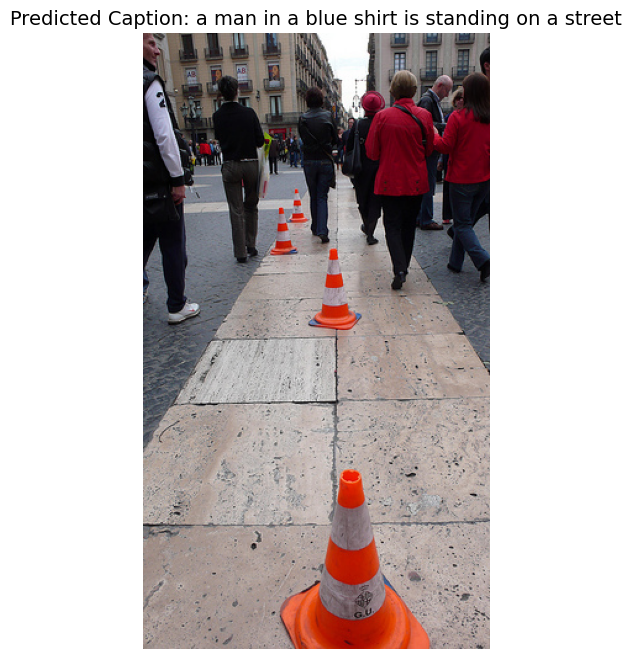

Image ID: 4546029322
Actual Captions:
- startseq  in this picture we see multiple people crossing a courtyard with a line of traffic cones dissecting it  endseq
- startseq  a group of men and women avoid orange cones as they explore an open town square area  endseq
- startseq  a crowd of variously attired people is walking along a line of orange traffic cones  endseq
- startseq  orange and white hazard cones are resting on street tiles  endseq
- startseq  a group of people walking away from the photographer  endseq
Predicted Caption: a man in a blue shirt is standing on a street
--------------------------------------------------


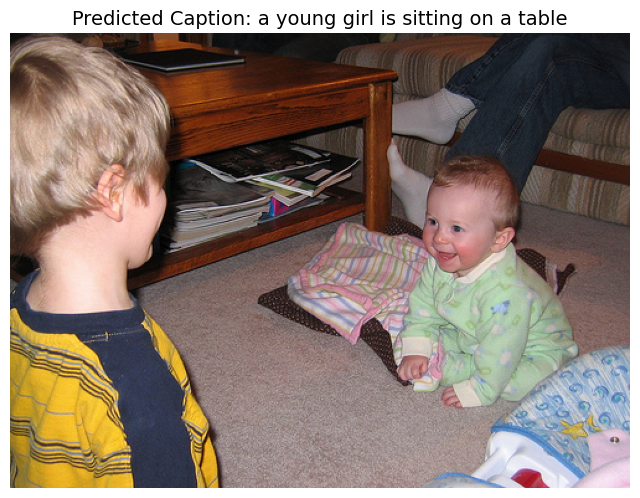

Image ID: 120764850
Actual Captions:
- startseq  a baby on the floor laughing at an older another child  endseq
- startseq  an older sibling and a baby in the living room  endseq
- startseq  a cute baby is smiling at another child  endseq
- startseq  a boy looks on as a baby laughs  endseq
- startseq  toddler playing with baby  endseq
Predicted Caption: a young girl is sitting on a table
--------------------------------------------------


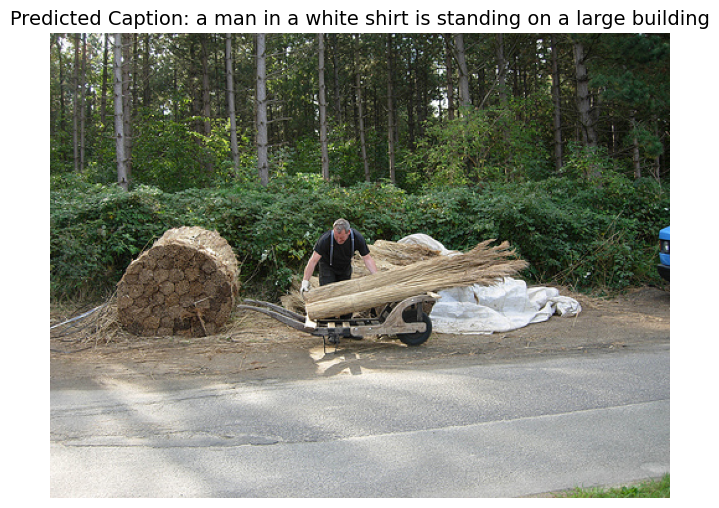

Image ID: 2912210904
Actual Captions:
- startseq  a man loads trees onto a cart on the side of a road  endseq
- startseq  a man putting bundles of hay onto a cart  endseq
- startseq  a man is putting large logs onto a cart  endseq
- startseq  a man with a cart loads plant material  endseq
- startseq  a man works on the side of the road  endseq
Predicted Caption: a man in a white shirt is standing on a large building
--------------------------------------------------


In [26]:
import matplotlib.pyplot as plt

# Load a few test image IDs
test_image_ids = test[:5]  # Take the first 5 images from the test set

# Generate captions for each test image
for image_id in test_image_ids:
    # Get the actual captions
    actual_captions = image_to_caption_mapping[image_id]
    # Get the image features
    image_features = loaded_features[image_id].reshape(1, -1)
    # Generate the predicted caption
    predicted_caption = predict_caption(model, image_features, tokenizer, max_caption_length)
    
    # Load and display the image
    img_path = os.path.join(img_dir, f"{image_id}.jpg")  # Adjust extension if needed
    img = Image.open(img_path)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Caption: {predicted_caption}", fontsize=14)
    plt.show()
    
    print(f"Image ID: {image_id}")
    print("Actual Captions:")
    for caption in actual_captions:
        print(f"- {caption}")
    print(f"Predicted Caption: {predicted_caption}")
    print("-" * 50)


In [25]:
model.save('model.keras')

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_features      │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_dense       │ (None, 256)       │    131,328 │ image_features[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding_layer     │ (None, 80, 256)   │  5,122,816 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 80)        │          0 │ caption_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_repeat      │ (None, 80, 256)   │          0 │ feature_dense[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_lstm       │ (None, 80, 256)   │    525,312 │ Embedding_layer[… │
│ (LSTM)              │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dot (Dot) │ (None, 80, 80)    │          0 │ feature_repeat[0… │
│                     │                   │            │ sequence_lstm[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_scores    │ (None, 80, 80)    │          0 │ attention_dot[0]… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 80, 256)   │          0 │ attention_scores… │
│                     │                   │            │ sequence_lstm[0]… │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256)       │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 512)       │          0 │ lambda_1[0][0],   │
│ (Concatenate)       │                   │            │ feature_dense[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 256)       │    131,328 │ decoder_input[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 20011)     │  5,142,827 │ decoder_dense[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,160,835 (126.50 MB)

 Trainable params: 11,053,611 (42.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,107,224 (84.33 MB)

In [28]:
model.save('train.h5')